<a href="https://colab.research.google.com/github/msalvati1997/energy_meter/blob/main/Detect_energy_of_a_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/msalvati1997/energy_meter/main/case_study/results.csv?token=GHSAT0AAAAAABYLICDDZ5VE4EQUQT7M4AT6Y3M2YLQ', parse_dates=['time'])

In [3]:
dataset

,Unnamed: 0,time,power
0,0,2022-11-10 08:42:48.677000+00:00,3.744788
1,1,2022-11-10 08:42:49.180000+00:00,7.637335
2,2,2022-11-10 08:42:49.684000+00:00,0.032518
3,3,2022-11-10 08:42:50.187000+00:00,0.001116
4,4,2022-11-10 08:42:50.692000+00:00,0.000923
...,...,...,...
2896,2896,2022-11-10 09:07:21.052000+00:00,0.000895
2897,2897,2022-11-10 09:07:21.561000+00:00,0.001022
2898,2898,2022-11-10 09:07:22.063000+00:00,0.000957
2899,2899,2022-11-10 09:07:22.566000+00:00,0.001170


In [4]:
dataset = dataset.sort_values(by=['time']).reset_index(drop=True).to_numpy()  # Sort and convert to numpy array

In [5]:
dataset

array([[0, Timestamp('2022-11-10 08:42:48.677000+0000', tz='UTC'),
        3.744788320021226],
       [1, Timestamp('2022-11-10 08:42:49.180000+0000', tz='UTC'),
        7.637335232038103],
       [2, Timestamp('2022-11-10 08:42:49.684000+0000', tz='UTC'),
        0.032518271429091],
       ...,
       [2898, Timestamp('2022-11-10 09:07:22.063000+0000', tz='UTC'),
        0.0009571159296299],
       [2899, Timestamp('2022-11-10 09:07:22.566000+0000', tz='UTC'),
        0.0011697160770632],
       [2900, Timestamp('2022-11-10 09:07:23.070000+0000', tz='UTC'),
        0.000885917794769]], dtype=object)

In [6]:
# Split into 2 arrays
values = [float(i[2]) for i in dataset]  # Flow values, in float
values = np.array(values)

dates = [i[1].to_pydatetime() for i in dataset]
dates = np.array(dates)

In [7]:
flow = np.diff(values).tolist()
time = np.diff(dates).tolist()

In [10]:
time= [float(i.total_seconds()) for i in time]  # Flow values, in float

In [12]:
slopes = np.divide(flow, time) # (flow[i+1] - flow[i]) / (time[i+1] - time[i])
slopes = np.insert(slopes, 0, 0, axis=0) # Since we "lose" the first index, this one is 0, just for alignments

In [15]:
# ROLLING WINDOW
size = len(dataset)
rolling_window = []
rolling_window_indexes = []
RW = []
RWi = []
window_size = 240  # Seconds


# create the rollings windows
for line in range(size):
    limit_stamp = dates[line] + datetime.timedelta(seconds=window_size)
    for subline in range(line, size, 1):
        if dates[subline] <= limit_stamp:

            rolling_window.append(slopes[subline])  # Values of the slopes
            rolling_window_indexes.append(subline)  # Indexes of the respective values

        else:

            RW.append(rolling_window)
            if line != size: # To prevent clearing the last rolling window
                rolling_window = []

            RWi.append(rolling_window_indexes)
            if line != size:
                rolling_window_indexes = []

            break
else:
    # To get the last rolling window since it breaks before append
    RW.append(rolling_window)
    RWi.append(rolling_window_indexes)

In [16]:
t = 0.3  # Threshold
peaks = []

for index, rollWin in enumerate(RW):
    if rollWin[0] > t: # If the first value is greater of threshold
        top = rollWin[0] # Sets as a possible peak
        bottom = np.min(rollWin) # Finds the minimum of the peak

        if bottom < -t: # If less than the negative threshold
            bottomIndex = int(np.argmin(rollWin)) # Find it's index

            for peak in range(0, bottomIndex, 1): # Appends all points between the first index of the rolling window until the bottomIndex
                peaks.append(RWi[index][peak]) 


In [22]:
from matplotlib.dates import DateFormatter

date_form = DateFormatter("%H:%M:%S")  # Xlabel for the plot_values

def plot_values(dates=None, values=None, dates_indexes=None, values_indexes=None):
    """
    This function is to plot the water flow accordingly to the timestamps of measuring
    :param dates: array-like of pydatetimes
    :param values: array-like of floats
    :param dates_indexes: peak filtered dates
    :param values_indexes: peak filtered values
    :return:
    """

    global dataset

    plt.cla()  # Clears previous plots

    fig = plt.figure(1, figsize=(7, 7))
    ax1 = fig.add_subplot(111)

    ax1.plot(dates, values, 'c', label="Power")  # Plotting of all values
    ax1.plot(dates_indexes, values_indexes, "xr", label="peaks")  # Plotting of all peaks
    ax1.xaxis.set_major_formatter(date_form)

    # ax2 = ax1
    # ax1.plot(dates_indexes, values_indexes, "xr", label="peaks")  # Plotting of all peaks
    plt.xlabel("Timestamp of measure")
    plt.ylabel("Power")
    plt.legend()
    plt.title("Power  over time")
    plt.show()


def plot_slopes():
    """
        This function is to plot the slope that the water flow creates
    """
    plt.plot(slopes, label="slopes")
    plt.hlines(t, 0, len(values), linestyles="dashed", label="Threshold")
    plt.hlines(-t, 0, len(values), linestyles="dashed", label="Threshold")
    plt.plot(peaks, slopes[peaks], "^r", label="Detected peaks")

    plt.legend()
    plt.title("The slopes of the flow measures")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


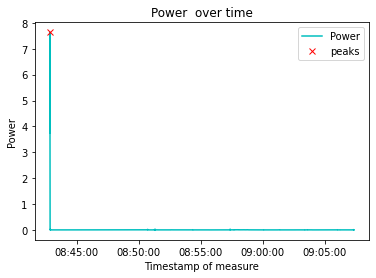

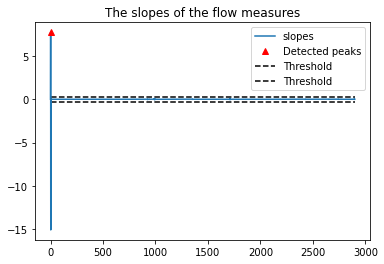

In [23]:
# PLOTTING
plot_values(dates, values, dates[peaks], values[peaks]) # The real dataset and the peaks
plot_slopes() # The slopes and the peaks